# 가위바위보 이미지를 통해서 분류기 만들기
실험 목표 : 내가 만든 가위바위보 사진을 학습해, 가위바위보를 분류할수있는 모델을 만들어보자



## 실험 정보

훈련 데이터

- 웹캠을 통해 직접찍은 왼손 가위바위보 사진 300장
- 64X64로 resize, 이후 표준화 /225

테스트 데이터

- 웹캠을 통해 직접찍은 오른손 가위바위보 사진 300장

### 사용한 모델
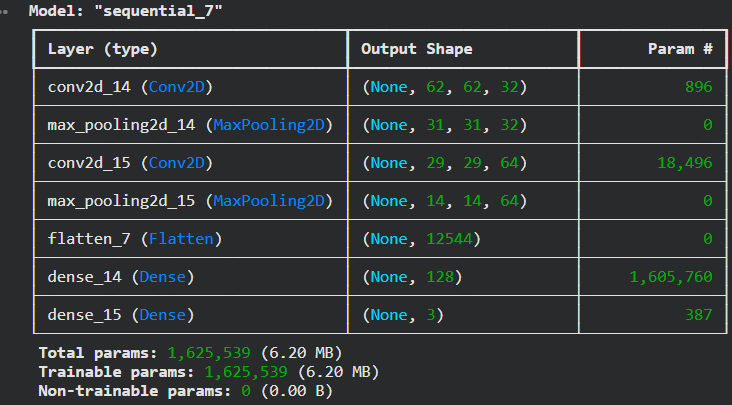


### 실험 결과

- 테스트1 : accuracy: 0.3195 - loss: 2.7939
- 테스트2 : accuracy: 0.3323 - loss: 13.2274 모델
n_channel_1 = 32
n_channel_2 = 64
n_dense = 128
n_train_epoch = 15
- 테스트 3 : accuracy: 0.3323 - loss: 7.0670 테스트2 + 정규화 시도

### 실험 샘플링을 통한 결과 분석

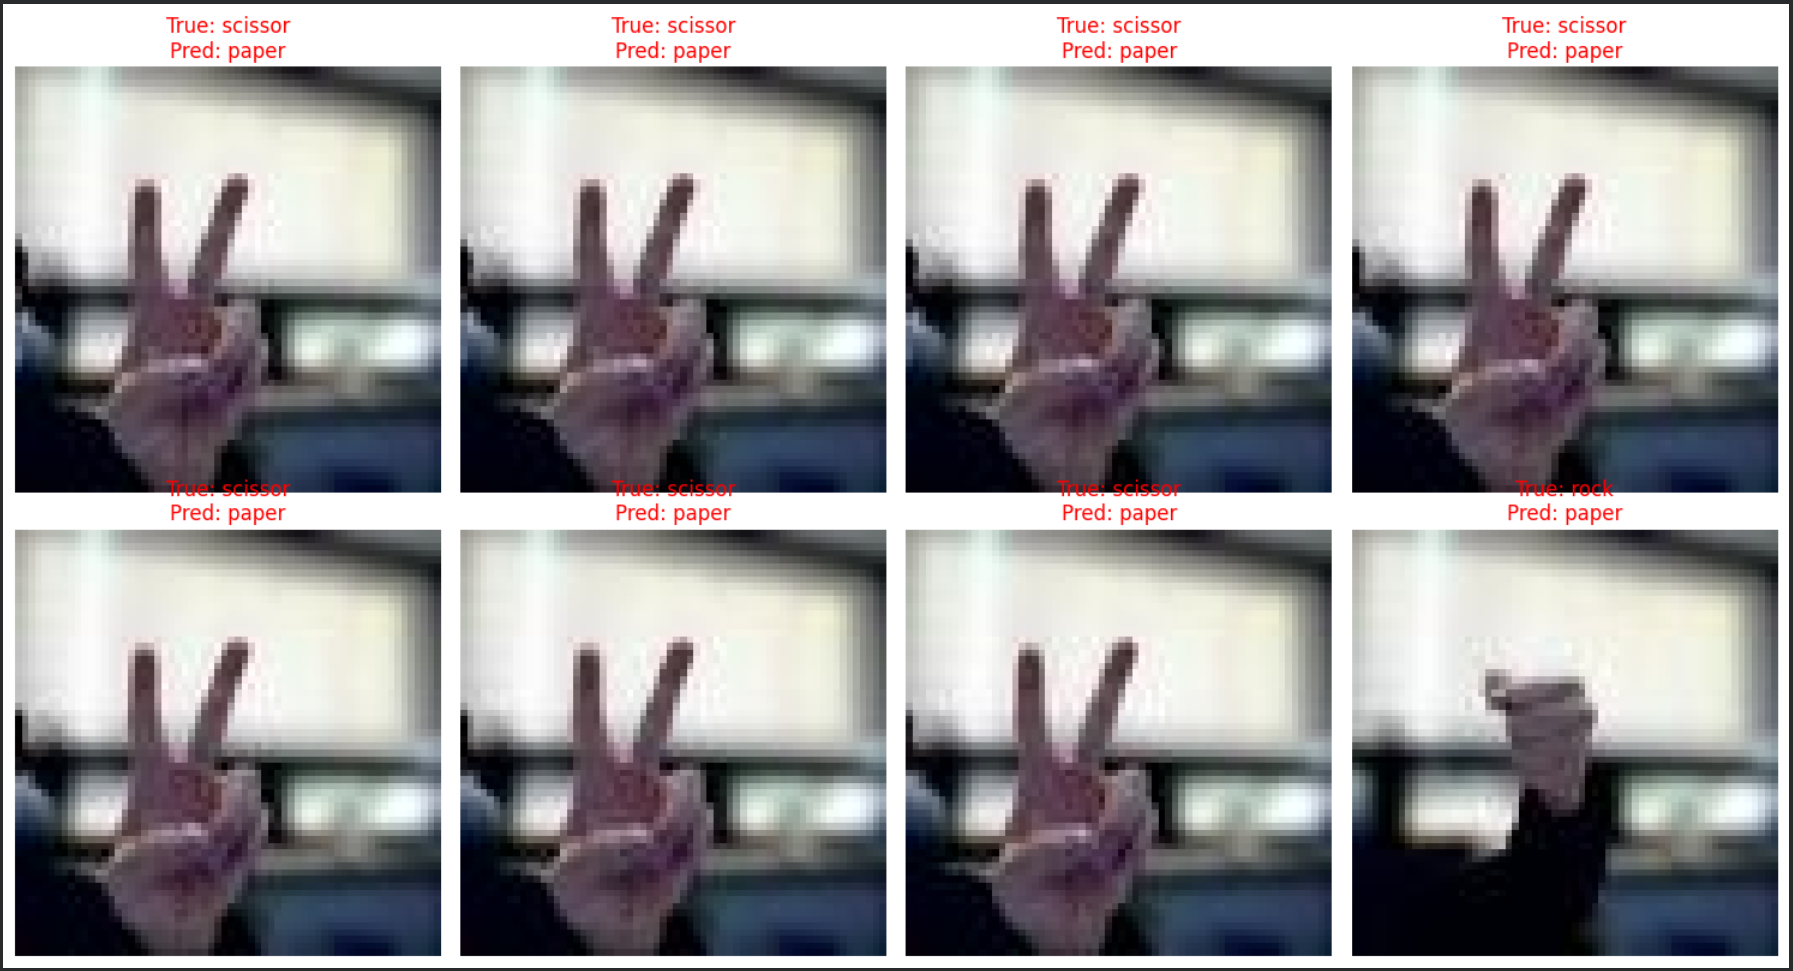

### 회고

생각보다 잘 예측을 못한다. 원본데이터에는 왼손이나 오른손, 크기나 각도 등 여러가지 요소들을 넣었고, 해상도를 64 X 64로 키웠지만, 정확도가 낮다.

예측을 못하는 이유라고 생각되는 부분은, 노이즈를 줄이지 못했거나 원본데이터가 너무 부족하다고 생각한다. 원본을 1000장쯤으로 늘려보면 어떨까 궁금하다.

## **2-1. 미니 프로젝트 : 가위바위보 분류기를 만들자**

지난 시간 배운 내용을 바탕으로 가위바위보 분류기를 만들도록 하겠습니다.
가장 먼저 해야 할 일은 뭘까요? 네, 첫 번째!!!! 데이터를 준비해야 합니다.
가위바위보 이미지를 모아 놓은 곳은 없으므로, 우리가 직접 사진을 찍어서 모아봅시다.

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.19.0
2.0.2


### 데이터를 준비하자

In [43]:
# 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

# 데이터 load 및 압축 해제

import os
import zipfile

# 데이터 루트 경로 - 미리 다운받아둔 데이터로 실험 진행
data_path = '/content/drive/MyDrive/Colab Notebooks/Data/Rock_Scissor_Paper'
# Fix: Assuming zip files are directly in data_path, not a nested 'Rock_Scissor_Paper' subfolder.
rps_path = data_path

# 압축 파일 목록
zip_files = {
    'rock.zip': 'rock',
    'scissor.zip': 'scissor',
    'paper.zip': 'paper'
}

for zip_name, folder_name in zip_files.items():
    zip_path = os.path.join(rps_path, zip_name)           # zip 파일 전체 경로
    extract_dir = os.path.join(rps_path, folder_name)     # 압축 해제될 폴더

    # 폴더 없으면 생성
    os.makedirs(extract_dir, exist_ok=True)

    print(f"🔍 압축 해제 중: {zip_name} → {extract_dir}")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
    except FileNotFoundError:
        print(f"⚠️ 경고: '{zip_name}' 파일을 찾을 수 없습니다. 해당 파일을 '{rps_path}'에 업로드했는지 확인해주세요.")
    except Exception as e:
        print(f"❌ 압축 해제 중 오류 발생 '{zip_name}': {e}")

print("✅ 모든 압축 해제 완료!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔍 압축 해제 중: rock.zip → /content/drive/MyDrive/Colab Notebooks/Data/Rock_Scissor_Paper/rock
🔍 압축 해제 중: scissor.zip → /content/drive/MyDrive/Colab Notebooks/Data/Rock_Scissor_Paper/scissor
🔍 압축 해제 중: paper.zip → /content/drive/MyDrive/Colab Notebooks/Data/Rock_Scissor_Paper/paper
✅ 모든 압축 해제 완료!


In [2]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


이제 가위 이미지를 불러와서 28x28 사이즈로 변경할 겁니다. 아래 코드를 실행해보세요. 이미지의 크기가 28x28 로 바뀌었나요?

In [44]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")

	print(len(images), " images to be resized.")

    # 파일마다 모두 64x64 사이즈로 바꾸어 저장합니다.
	target_size=(64,64)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.Resampling.LANCZOS)
		new_img.save(img, "JPEG")

	print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/Colab Notebooks/Data/Rock_Scissor_Paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

109  images to be resized.
109  images resized.
가위 이미지 resize 완료!


In [45]:
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/Colab Notebooks/Data/Rock_Scissor_Paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

102  images to be resized.
102  images resized.
보 이미지 resize 완료!


In [46]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/Colab Notebooks/Data/Rock_Scissor_Paper/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

110  images to be resized.
110  images resized.
바위 이미지 resize 완료!


In [47]:
# 이미지 - 라벨 (하나하나를 맞춰주는 코드를 작성한다)

import numpy as np

def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    imgs = []
    labels = []

    # 1. scissor
    for file in glob.iglob(os.path.join(img_path, 'scissor', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(0)   # 가위 : 0

    # 2. rock
    for file in glob.iglob(os.path.join(img_path, 'rock', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(1)   # 바위 : 1

    # 3. paper
    for file in glob.iglob(os.path.join(img_path, 'paper', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(2)   # 보 : 2

    # 리스트 → 넘파이 배열로 변환
    imgs = np.stack(imgs, axis=0)              # (N, H, W, C)
    labels = np.array(labels, dtype=np.int32)  # (N,)

    print("학습데이터(x_train)의 이미지 개수는", len(labels), "입니다.")
    return imgs, labels

# 사용 예시
x_train, y_train = load_data(rps_path)
x_train_norm = x_train / 255.0

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

학습데이터(x_train)의 이미지 개수는 321 입니다.
x_train shape: (321, 64, 64, 3)
y_train shape: (321,)


라벨:  0


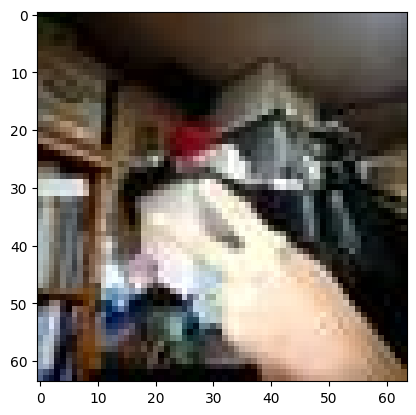

In [48]:
# 이미지 불러오기
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 딥러닝 네트워크 설계하기


In [60]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
# 아래의 하이퍼파라미터는 예시입니다. 높은 인식률을 얻기 위해 하이퍼파라미터를 수정해 보세요.
n_channel_1=32
n_channel_2=64
n_dense=128
n_train_epoch=20

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(64,64,3))) # Changed input_shape from (28,28,3) to (64,64,3)
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,539 (6.20 MB)

 Trainable params: 1,625,539 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

### **딥러닝 네트워크 학습시키기**


잘 설계가 되었다면, 이제 학습을 시켜봅시다. 아마도 여러분들의 데이터는 거의 비슷비슷할 것이기 때문에 accuracy가 꽤 높게 나올 것입니다.

In [68]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.7619 - loss: 1.0106
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.8196 - loss: 0.7586
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.6046 - loss: 0.8802
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8475 - loss: 0.5320
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8811 - loss: 0.3870
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9030 - loss: 0.2705
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9577 - loss: 0.1744
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9786 - loss: 0.1105
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.9665 - loss: 0.1043
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9898 - loss: 0.0567
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.9869 - loss: 0.0433
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step

In [51]:
# 테스트용 데이터 불러오기

# 압축 파일 목록
zip_files = {
    'rock_test.zip': 'rock_test',
    'scissor_test.zip': 'scissor_test',
    'paper_test.zip': 'paper_test'
}

for zip_name, folder_name in zip_files.items():
    zip_path = os.path.join(rps_path, zip_name)           # zip 파일 전체 경로
    extract_dir = os.path.join(rps_path, folder_name)     # 압축 해제될 폴더

    # 폴더 없으면 생성
    os.makedirs(extract_dir, exist_ok=True)

    print(f"🔍 압축 해제 중: {zip_name} → {extract_dir}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

print("✅ 모든 압축 해제 완료!")

🔍 압축 해제 중: rock_test.zip → /content/drive/MyDrive/Colab Notebooks/Data/Rock_Scissor_Paper/rock_test
🔍 압축 해제 중: scissor_test.zip → /content/drive/MyDrive/Colab Notebooks/Data/Rock_Scissor_Paper/scissor_test
🔍 압축 해제 중: paper_test.zip → /content/drive/MyDrive/Colab Notebooks/Data/Rock_Scissor_Paper/paper_test
✅ 모든 압축 해제 완료!


In [52]:
# 이미지 전처리
rock_test_img_path = os.path.join(rps_path, 'rock_test')
resize_images(rock_test_img_path)
scissor_test_img_path = os.path.join(rps_path, 'scissor_test')
resize_images(scissor_test_img_path)
paper_test_img_path = os.path.join(rps_path, 'paper_test')
resize_images(paper_test_img_path)

102  images to be resized.
102  images resized.
107  images to be resized.
107  images resized.
104  images to be resized.
104  images resized.


In [53]:
# 이미지 - 라벨 (하나하나를 맞춰주는 코드를 작성한다)

import numpy as np

def load_test_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    imgs = []
    labels = []

    # 1. scissor
    for file in glob.iglob(os.path.join(img_path, 'scissor_test', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(0)   # 가위 : 0

    # 2. rock
    for file in glob.iglob(os.path.join(img_path, 'rock_test', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(1)   # 바위 : 1

    # 3. paper
    for file in glob.iglob(os.path.join(img_path, 'paper_test', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(2)   # 보 : 2

    # 리스트 → 넘파이 배열로 변환
    imgs = np.stack(imgs, axis=0)              # (N, H, W, C)
    labels = np.array(labels, dtype=np.int32)  # (N,)

    print("학습데이터(x_test)의 이미지 개수는", len(labels), "입니다.")
    return imgs, labels

# 사용 예시
x_test, y_test = load_test_data(rps_path)
x_test_norm = x_test / 255.0

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

학습데이터(x_test)의 이미지 개수는 313 입니다.
x_test shape: (313, 64, 64, 3)
y_test shape: (313,)


테스트용 데이터가 준비되었으니, 위에서 훈련시킨 model을 사용하여 test_accuracy를 측정해 봅시다.

In [71]:
# 테스트

test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 1s - 56ms/step - accuracy: 0.3323 - loss: 7.0670
test_loss: 7.066995143890381 
test_accuracy: 0.3322683572769165


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


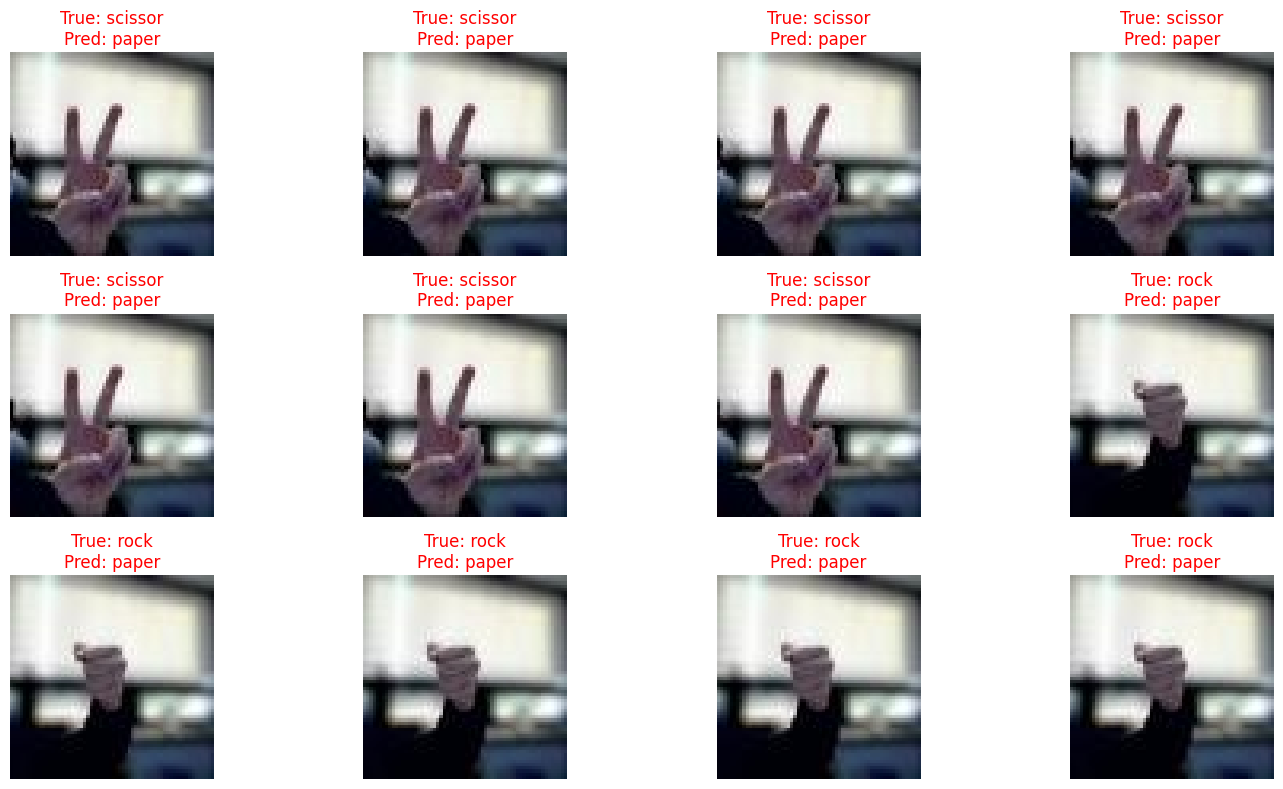

In [64]:
# 시각화

import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름 매핑
class_names = ['scissor', 'rock', 'paper']   # 0, 1, 2

# 모델 예측
pred = model.predict(x_test)          # (N, 3)
pred_label = np.argmax(pred, axis=1)  # 예측 라벨

# 원하는 만큼 출력
start_idx = 100
num_images = 12
plt.figure(figsize=(15, 8))

for i in range(num_images):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test[start_idx+i])
    plt.axis('off')

    true_name = class_names[y_test[start_idx+i]]
    pred_name = class_names[pred_label[start_idx+i]]

    # 정답 / 예측 출력
    color = 'green' if y_test[start_idx+i] == pred_label[start_idx+i] else 'red'
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color)

plt.tight_layout()
plt.show()